In [1]:
!python -m pip install shapely


In [2]:
import shapely
print("Shapely is ready ✅")


Shapely is ready ✅


In [3]:
import pandas as pd
import logging
from shapely.geometry import Polygon, Point
import numpy as np

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def read_data(path=None):
    """Load the UNSW F1 2024 dataset, defaulting to repo structure if no path is given."""
    if path:
        return pd.read_csv(f"{path}")
    else:
        return pd.read_csv("data/UNSW F12024.csv")


def filter_melbourne(df):
    """Keep only laps from the Melbourne circuit."""
    return df[df["M_TRACKID"] == 0]


def remove_na(df):
    return df.dropna(subset=["M_WORLDPOSITIONX_1", "M_WORLDPOSITIONY_1"]).reset_index(
        drop=True
    )


def re_index(df):
    """Add a global 0-based lap index per unique session/lap combination."""

    # Drop duplicates to get unique session/lap pairs in order
    unique_laps = df[["M_SESSIONUID", "M_CURRENTLAPNUM"]].drop_duplicates()

    # Sort by session, then lap
    unique_laps = unique_laps.sort_values(["M_SESSIONUID", "M_CURRENTLAPNUM"])

    # Assign a global 0-based index
    unique_laps["lap_index"] = range(len(unique_laps))

    # Map the lap_index back to all rows in the original dataframe
    df = df.merge(unique_laps, on=["M_SESSIONUID", "M_CURRENTLAPNUM"], how="left")

    return df


def track_slice(df):
    df = df[
        (df["M_WORLDPOSITIONX_1"] >= 0)
        & (df["M_WORLDPOSITIONX_1"] <= 600)
        & (df["M_WORLDPOSITIONY_1"] >= -200)
        & (df["M_WORLDPOSITIONY_1"] <= 600)
    ]

    track_points = np.array(
        [
            [152.5310179012927, 413.5544859306186],
            [161.76398481864388, 423.11538718965284],
            [572, 423],
            [572.051098447852, -131.86683911251717],
            [564.8183173166642, -138.23284559314058],
            [152, -138],
        ],
        float,
    )

    polygon = Polygon(track_points)

    mask = df.apply(
        lambda row: polygon.contains(
            Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
        ),
        axis=1,
    )

    return df[mask]


def remove_repeated_point_laps(df, max_repeats=10):
    """
    Remove laps that have any (X, Y) point repeated more than max_repeats times.
    """
    # Count occurrences of each (x, y) per lap
    repeated_counts = (
        df.groupby(["lap_index", "M_WORLDPOSITIONX_1", "M_WORLDPOSITIONY_1"])
        .size()
        .reset_index(name="count")
    )

    # Laps to discard
    discard_laps = repeated_counts[repeated_counts["count"] > max_repeats][
        "lap_index"
    ].unique()

    # Filter out those laps
    df_clean = df[~df["lap_index"].isin(discard_laps)]

    return df_clean


def read_process_left(path=None):
    """Load and restrict the left track limits to expected coordinate bounds."""
    if path:
        left = pd.read_csv(f"{path}")
    else:
        left = pd.read_csv("data/f1sim-ref-left.csv")

    # Restrict to the same bounds as track_slice
    left = left[
        (left["WORLDPOSX"] >= 120)
        & (left["WORLDPOSX"] <= 600)
        & (left["WORLDPOSY"] >= -200)
        & (left["WORLDPOSY"] <= 600)
    ]

    return left


def read_process_right(path=None):
    """Load and restrict the right track limits to expected coordinate bounds."""
    if path:
        right = pd.read_csv(f"{path}")
    else:
        right = pd.read_csv("data/f1sim-ref-right.csv")

    # Restrict to the same bounds as track_slice
    right = right[
        (right["WORLDPOSX"] >= 120)
        & (right["WORLDPOSX"] <= 600)
        & (right["WORLDPOSY"] >= -200)
        & (right["WORLDPOSY"] <= 600)
    ]

    return right


def interpolate_steering(df):
    df["M_FRONTWHEELSANGLE"] = (
        df.groupby(["lap_index"])["M_FRONTWHEELSANGLE"]
        .transform(lambda g: g.interpolate(method="linear"))
        .ffill()
        .bfill()
    )

    return df


def enforce_track_limits(df, left, right):
    """Remove laps where any telemetry point exceeds a given distance from track edges."""
    threshold = 5
    # Combine track edges
    track_points = np.vstack(
        [
            left[["WORLDPOSX", "WORLDPOSY"]].values,
            right[["WORLDPOSX", "WORLDPOSY"]].values,
        ]
    )
    tracklims = Polygon(track_points)

    df["inside_track"] = df.apply(
        lambda row: tracklims.contains(
            Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
        ),
        axis=1,
    )

    df["dist_to_track"] = df.apply(
        lambda row: (
            0
            if row["inside_track"]
            else tracklims.exterior.distance(
                Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
            )
        ),
        axis=1,
    )

    offtrack_laps = df[df["dist_to_track"] > threshold][["lap_index"]].drop_duplicates()

    df = df.merge(offtrack_laps, on=["lap_index"], how="left", indicator=True)
    df = df[df["_merge"] == "left_only"].drop(
        columns=["_merge", "inside_track", "dist_to_track"]
    )

    return df


def remove_short_laps(df, min_points=700):
    """Remove laps that have fewer than min_points telemetry points."""
    # Count points per lap
    lap_counts = df.groupby("lap_index").size().reset_index(name="n_points")

    # Keep only laps with enough points
    valid_laps = lap_counts[lap_counts["n_points"] >= min_points]["lap_index"]

    df = df[df["lap_index"].isin(valid_laps)]
    return df


def compute_turning_window(df):
    # Apex coordinates
    t1_apex = (375.57, 191.519)
    t2_apex = (368.93, 90)
    turn_radius = 50  # meters

    # Compute distance to each apex
    df["dist_to_t1_apex"] = np.sqrt(
        (df["M_WORLDPOSITIONX_1"] - t1_apex[0]) ** 2
        + (df["M_WORLDPOSITIONY_1"] - t1_apex[1]) ** 2
    )

    df["dist_to_t2_apex"] = np.sqrt(
        (df["M_WORLDPOSITIONX_1"] - t2_apex[0]) ** 2
        + (df["M_WORLDPOSITIONY_1"] - t2_apex[1]) ** 2
    )

    # Binary columns indicating if point is inside turning window
    df["is_t1_window"] = df["dist_to_t1_apex"] <= turn_radius
    df["is_t2_window"] = df["dist_to_t2_apex"] <= turn_radius
    return df


def initialise_lap_summary(df):
    """
    Create a summary dataframe per lap with lap index and sector_time.
    sector_time is computed as the difference between the first and last CURRENTLAPTIME in seconds.
    """

    def time_to_seconds(t):
        """Convert 'M:SS.sss' string to seconds."""
        mins, secs = t.split(":")
        return float(mins) * 60 + float(secs)

    summary_rows = []

    for lap_idx in df["lap_index"].unique():
        lap = df[df["lap_index"] == lap_idx].sort_values("M_LAPDISTANCE_1")
        start_time = time_to_seconds(lap.iloc[0]["CURRENTLAPTIME"])
        end_time = time_to_seconds(lap.iloc[-1]["CURRENTLAPTIME"])
        sector_time = end_time - start_time
        summary_rows.append({"index": lap_idx, "sector_time": sector_time})

    summary_df = pd.DataFrame(summary_rows)
    return summary_df


def remove_redundant_cols(df):
    """
    REDUNDANT VARIABLES: Removes session metadata, duplicates, and irrelevant columns that are either
    redundant, empty, or not needed for modeling/analysis, leaving only clean and relevant features.
    """
    red_cols = [
        "CREATED_ON",
        "GAMEHOST",
        "DEVICENAME",
        "SESSION_GUID",
        "R_SESSION",
        "R_GAMEHOST",
        "M_PACKETFORMAT",
        "M_GAMEMAJORVERSION",
        "M_GAMEMINORVERSION",
        "M_FRAMEIDENTIFIER",
        "R_STATUS",
        "M_CURRENTLAPNUM_1",
        "M_TRACKID",
        "R_TRACKID",
        "M_LAPINVALID",
        "M_SECTOR1TIMEMSPART_1",
        "M_SECTOR1TIMEMINUTESPART_1",
        "M_SECTOR2TIMEMSPART_1",
        "M_SECTOR2TIMEMINUTESPART_1",
        "M_SECTOR_1",
        "M_CURRENTLAPINVALID_1",
        "M_DRIVERSTATUS_1",
        "FRAMEID",
        "M_TOTALLAPS",
        "M_SESSIONTYPE",
        "R_FAV_TEAM",
        "M_TYRESSURFACETEMPERATURE_RL_1",
        "M_TYRESSURFACETEMPERATURE_RR_1",
        "M_TYRESSURFACETEMPERATURE_FL_1",
        "M_TYRESSURFACETEMPERATURE_FR_1",
        "M_TYRESINNERTEMPERATURE_RL_1",
        "M_TYRESINNERTEMPERATURE_RR_1",
        "M_TYRESINNERTEMPERATURE_FL_1",
        "M_TYRESINNERTEMPERATURE_FR_1",
        "M_ENGINETEMPERATURE_1",
    ]

    df = df.drop(columns=red_cols)

    return df


def data_pipeline(path=None, left_path=None, right_path=None):
    """
    Complete data pipeline:
        - load data
        - filter for Melbourne laps
        - slice track coordinates
        - re-index the data
        - enforce track limits
        - remove laps with insufficient data
    """
    df = read_data(path)
    logger.info("Data loaded successfully.")

    # Removes laps from trakcs that are not melbourne
    df = filter_melbourne(df)
    logger.info("Filtered Melbourne laps.")

    # Removes rows with NA (X,Y) coordinates
    df = remove_na(df)
    logger.info("Removed data points with missing (x,y)")

    # Re-index the laps for easier access
    df = re_index(df)
    logger.info("Re-indexed data.")

    # Removing uselss/redundant columns from the data
    df = remove_redundant_cols(df)
    logger.info("Removed redundant columns")
    # Slice the track data to be between selected track start and finish lines for this sector
    df = track_slice(df)
    logger.info("Sliced track coordinates.")

    # Load track limits
    left = read_process_left(left_path)
    right = read_process_right(right_path)
    logger.info("Track limits loaded.")

    # Enforce track limits, to ensure laps wildly off track are removed.
    df = enforce_track_limits(df, left, right)
    logger.info("Enforced track limits.")

    # Remove laps with too few data points.
    df = remove_short_laps(df)
    logger.info("Removed laps with insufficient data.")

    # Compute turning window metrics
    df = compute_turning_window(df)
    logger.info("Computed turning window metrics")

    df = interpolate_steering(df)
    logger.info("Interpolating steering data")

    # Creates a summary df with index and sector_time as columns
    summary_df = initialise_lap_summary(df)
    logger.info("Created summary dataframe.")
    return df, left, right, summary_df

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

f1_left_limit = pd.read_csv("f1sim-ref-left.csv")
f1_right_limit = pd.read_csv("f1sim-ref-right.csv")
f1_turns_limit = pd.read_csv("f1sim-ref-turns.csv")

def plot_racing_line_t1_t2(
    df, left, right,
    x_col="M_WORLDPOSITIONX_1",
    y_col="M_WORLDPOSITIONY_1",
    color_col="exit_T2_speed",
    lower_limit=None, upper_limit=None,
    cmap="plasma_r",  # reversed gradient
    track_linestyle="--",
    show_apex=True,
    apex_marker="X",
):
    """
    Plots racing line from start of Turn 1 to end of Turn 2.
    Coloring can be any telemetry variable with optional numeric filtering.
    Track boundaries and apex shown.

    Example Usage: 
    plot_racing_line_t1_t2(f1_cleaned_df, f1_left_limit, f1_right_limit,
                       color_col="exit_T2_speed",
                       lower_limit=240, upper_limit=250)
    """

    # --- Copy df ---
    plot_df = df.copy()

    # --- Apply numeric filters ---
    if lower_limit is not None:
        plot_df = plot_df[plot_df[color_col] >= lower_limit]
    if upper_limit is not None:
        plot_df = plot_df[plot_df[color_col] <= upper_limit]

    # --- Sort by color to emphasize high values ---
    if color_col in plot_df:
        plot_df = plot_df.sort_values(by=color_col)

    # --- Extract variables ---
    x = plot_df[x_col]
    y = plot_df[y_col]
    colors = plot_df[color_col] if color_col in plot_df else "pink"

    # --- Hardcoded zoom covering Turn 1 → Turn 2 ---
    xlim = (315, 425)  # start of T1 → end of T2
    ylim = (0, 260)    # min/max Y across T1+T2

    # --- Plot ---
    plt.figure(figsize=(12, 10))

    # Track boundaries
    plt.plot(
        left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))]
            .sort_values(by="FRAME")["WORLDPOSX"],
        left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))]
            .sort_values(by="FRAME")["WORLDPOSY"],
        linestyle=track_linestyle, color="lightgray", linewidth=1.5, label="Left boundary"
    )
    plt.plot(
        right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))]
            .sort_values(by="FRAME")["WORLDPOSX"],
        right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))]
            .sort_values(by="FRAME")["WORLDPOSY"],
        linestyle=track_linestyle, color="slategray", linewidth=1.5, label="Right boundary"
    )

    # Racing line
    sc = plt.scatter(x, y, c=colors, cmap=cmap, s=3, alpha=0.7)
    if isinstance(colors, pd.Series) and pd.api.types.is_numeric_dtype(colors):
        plt.colorbar(sc, label=color_col)

    # Optional apex markers (T1 + T2)
    if show_apex:
        # Apex points from your CSV (hardcoded for T1+T2)
        t1_apex = (375.57, 191.519)
        t2_apex = (368.93, 90)
        plt.scatter(*t1_apex, marker=apex_marker, color="lime", s=100, label="T1 Apex", zorder=5)
        plt.scatter(*t2_apex, marker=apex_marker, color="aqua", s=100, label="T2 Apex", zorder=5)

    # Labels & title
    limit_text = ""
    if lower_limit is not None or upper_limit is not None:
        low = lower_limit if lower_limit is not None else ""
        high = upper_limit if upper_limit is not None else ""
        limit_text = f" [{low}–{high}]"

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"Turns 1–2 Racing Line by {color_col}{limit_text}")
    plt.axis("equal")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.legend()
    plt.show()

In [5]:
import pandas as pd
import logging
from shapely.geometry import Polygon, Point
import numpy as np

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def read_data(path=None):
    """Load the UNSW F1 2024 dataset, defaulting to repo structure if no path is given."""
    if path:
        return pd.read_csv(f"{path}")
    else:
        return pd.read_csv("data/UNSW F12024.csv")


def filter_melbourne(df):
    """Keep only laps from the Melbourne circuit."""
    return df[df["M_TRACKID"] == 0]


def remove_na(df):
    return df.dropna(subset=["M_WORLDPOSITIONX_1", "M_WORLDPOSITIONY_1"]).reset_index(
        drop=True
    )


def re_index(df):
    """Add a global 0-based lap index per unique session/lap combination."""

    # Drop duplicates to get unique session/lap pairs in order
    unique_laps = df[["M_SESSIONUID", "M_CURRENTLAPNUM"]].drop_duplicates()

    # Sort by session, then lap
    unique_laps = unique_laps.sort_values(["M_SESSIONUID", "M_CURRENTLAPNUM"])

    # Assign a global 0-based index
    unique_laps["lap_index"] = range(len(unique_laps))

    # Map the lap_index back to all rows in the original dataframe
    df = df.merge(unique_laps, on=["M_SESSIONUID", "M_CURRENTLAPNUM"], how="left")

    return df


def track_slice(df):
    df = df[
        (df["M_WORLDPOSITIONX_1"] >= 0)
        & (df["M_WORLDPOSITIONX_1"] <= 600)
        & (df["M_WORLDPOSITIONY_1"] >= -200)
        & (df["M_WORLDPOSITIONY_1"] <= 600)
    ]

    track_points = np.array(
        [
            [152.5310179012927, 413.5544859306186],
            [161.76398481864388, 423.11538718965284],
            [572, 423],
            [572.051098447852, -131.86683911251717],
            [564.8183173166642, -138.23284559314058],
            [152, -138],
        ],
        float,
    )

    polygon = Polygon(track_points)

    mask = df.apply(
        lambda row: polygon.contains(
            Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
        ),
        axis=1,
    )

    return df[mask]


def remove_repeated_point_laps(df, max_repeats=10):
    """
    Remove laps that have any (X, Y) point repeated more than max_repeats times.
    """
    # Count occurrences of each (x, y) per lap
    repeated_counts = (
        df.groupby(["lap_index", "M_WORLDPOSITIONX_1", "M_WORLDPOSITIONY_1"])
        .size()
        .reset_index(name="count")
    )

    # Laps to discard
    discard_laps = repeated_counts[repeated_counts["count"] > max_repeats][
        "lap_index"
    ].unique()

    # Filter out those laps
    df_clean = df[~df["lap_index"].isin(discard_laps)]

    return df_clean


def read_process_left(path=None):
    """Load and restrict the left track limits to expected coordinate bounds."""
    if path:
        left = pd.read_csv(f"{path}")
    else:
        left = pd.read_csv("data/f1sim-ref-left.csv")

    # Restrict to the same bounds as track_slice
    left = left[
        (left["WORLDPOSX"] >= 120)
        & (left["WORLDPOSX"] <= 600)
        & (left["WORLDPOSY"] >= -200)
        & (left["WORLDPOSY"] <= 600)
    ]

    return left


def read_process_right(path=None):
    """Load and restrict the right track limits to expected coordinate bounds."""
    if path:
        right = pd.read_csv(f"{path}")
    else:
        right = pd.read_csv("data/f1sim-ref-right.csv")

    # Restrict to the same bounds as track_slice
    right = right[
        (right["WORLDPOSX"] >= 120)
        & (right["WORLDPOSX"] <= 600)
        & (right["WORLDPOSY"] >= -200)
        & (right["WORLDPOSY"] <= 600)
    ]

    return right


def interpolate_steering(df):
    df["M_FRONTWHEELSANGLE"] = (
        df.groupby(["lap_index"])["M_FRONTWHEELSANGLE"]
        .transform(lambda g: g.interpolate(method="linear"))
        .ffill()
        .bfill()
    )

    return df


def enforce_track_limits(df, left, right):
    """Remove laps where any telemetry point exceeds a given distance from track edges."""
    threshold = 5
    # Combine track edges
    track_points = np.vstack(
        [
            left[["WORLDPOSX", "WORLDPOSY"]].values,
            right[["WORLDPOSX", "WORLDPOSY"]].values,
        ]
    )
    tracklims = Polygon(track_points)

    df["inside_track"] = df.apply(
        lambda row: tracklims.contains(
            Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
        ),
        axis=1,
    )

    df["dist_to_track"] = df.apply(
        lambda row: (
            0
            if row["inside_track"]
            else tracklims.exterior.distance(
                Point(row["M_WORLDPOSITIONX_1"], row["M_WORLDPOSITIONY_1"])
            )
        ),
        axis=1,
    )

    offtrack_laps = df[df["dist_to_track"] > threshold][["lap_index"]].drop_duplicates()

    df = df.merge(offtrack_laps, on=["lap_index"], how="left", indicator=True)
    df = df[df["_merge"] == "left_only"].drop(
        columns=["_merge", "inside_track", "dist_to_track"]
    )

    return df


def remove_short_laps(df, min_points=700):
    """Remove laps that have fewer than min_points telemetry points."""
    # Count points per lap
    lap_counts = df.groupby("lap_index").size().reset_index(name="n_points")

    # Keep only laps with enough points
    valid_laps = lap_counts[lap_counts["n_points"] >= min_points]["lap_index"]

    df = df[df["lap_index"].isin(valid_laps)]
    return df


def compute_turning_window(df):
    # Apex coordinates
    t1_apex = (375.57, 191.519)
    t2_apex = (368.93, 90)
    turn_radius = 50  # meters

    # Compute distance to each apex
    df["dist_to_t1_apex"] = np.sqrt(
        (df["M_WORLDPOSITIONX_1"] - t1_apex[0]) ** 2
        + (df["M_WORLDPOSITIONY_1"] - t1_apex[1]) ** 2
    )

    df["dist_to_t2_apex"] = np.sqrt(
        (df["M_WORLDPOSITIONX_1"] - t2_apex[0]) ** 2
        + (df["M_WORLDPOSITIONY_1"] - t2_apex[1]) ** 2
    )

    # Binary columns indicating if point is inside turning window
    df["is_t1_window"] = df["dist_to_t1_apex"] <= turn_radius
    df["is_t2_window"] = df["dist_to_t2_apex"] <= turn_radius
    return df


def initialise_lap_summary(df):
    """
    Create a summary dataframe per lap with lap index and sector_time.
    sector_time is computed as the difference between the first and last CURRENTLAPTIME in seconds.
    """

    def time_to_seconds(t):
        """Convert 'M:SS.sss' string to seconds."""
        mins, secs = t.split(":")
        return float(mins) * 60 + float(secs)

    summary_rows = []

    for lap_idx in df["lap_index"].unique():
        lap = df[df["lap_index"] == lap_idx].sort_values("M_LAPDISTANCE_1")
        start_time = time_to_seconds(lap.iloc[0]["CURRENTLAPTIME"])
        end_time = time_to_seconds(lap.iloc[-1]["CURRENTLAPTIME"])
        sector_time = end_time - start_time
        summary_rows.append({"index": lap_idx, "sector_time": sector_time})

    summary_df = pd.DataFrame(summary_rows)
    return summary_df


def remove_redundant_cols(df):
    """
    REDUNDANT VARIABLES: Removes session metadata, duplicates, and irrelevant columns that are either
    redundant, empty, or not needed for modeling/analysis, leaving only clean and relevant features.
    """
    red_cols = [
        "CREATED_ON",
        "GAMEHOST",
        "DEVICENAME",
        "SESSION_GUID",
        "R_SESSION",
        "R_GAMEHOST",
        "M_PACKETFORMAT",
        "M_GAMEMAJORVERSION",
        "M_GAMEMINORVERSION",
        "M_FRAMEIDENTIFIER",
        "R_STATUS",
        "M_CURRENTLAPNUM_1",
        "M_TRACKID",
        "R_TRACKID",
        "M_LAPINVALID",
        "M_SECTOR1TIMEMSPART_1",
        "M_SECTOR1TIMEMINUTESPART_1",
        "M_SECTOR2TIMEMSPART_1",
        "M_SECTOR2TIMEMINUTESPART_1",
        "M_SECTOR_1",
        "M_CURRENTLAPINVALID_1",
        "M_DRIVERSTATUS_1",
        "FRAMEID",
        "M_TOTALLAPS",
        "M_SESSIONTYPE",
        "R_FAV_TEAM",
        "M_TYRESSURFACETEMPERATURE_RL_1",
        "M_TYRESSURFACETEMPERATURE_RR_1",
        "M_TYRESSURFACETEMPERATURE_FL_1",
        "M_TYRESSURFACETEMPERATURE_FR_1",
        "M_TYRESINNERTEMPERATURE_RL_1",
        "M_TYRESINNERTEMPERATURE_RR_1",
        "M_TYRESINNERTEMPERATURE_FL_1",
        "M_TYRESINNERTEMPERATURE_FR_1",
        "M_ENGINETEMPERATURE_1",
    ]

    df = df.drop(columns=red_cols)

    return df


def data_pipeline(path=None, left_path=None, right_path=None):
    """
    Complete data pipeline:
        - load data
        - filter for Melbourne laps
        - slice track coordinates
        - re-index the data
        - enforce track limits
        - remove laps with insufficient data
    """
    df = read_data(path)
    logger.info("Data loaded successfully.")

    # Removes laps from trakcs that are not melbourne
    df = filter_melbourne(df)
    logger.info("Filtered Melbourne laps.")

    # Removes rows with NA (X,Y) coordinates
    df = remove_na(df)
    logger.info("Removed data points with missing (x,y)")

    # Re-index the laps for easier access
    df = re_index(df)
    logger.info("Re-indexed data.")

    # Removing uselss/redundant columns from the data
    df = remove_redundant_cols(df)
    logger.info("Removed redundant columns")
    # Slice the track data to be between selected track start and finish lines for this sector
    df = track_slice(df)
    logger.info("Sliced track coordinates.")

    # Load track limits
    left = read_process_left(left_path)
    right = read_process_right(right_path)
    logger.info("Track limits loaded.")

    # Enforce track limits, to ensure laps wildly off track are removed.
    df = enforce_track_limits(df, left, right)
    logger.info("Enforced track limits.")

    # Remove laps with too few data points.
    df = remove_short_laps(df)
    logger.info("Removed laps with insufficient data.")

    # Compute turning window metrics
    df = compute_turning_window(df)
    logger.info("Computed turning window metrics")

    df = interpolate_steering(df)
    logger.info("Interpolating steering data")

    # Creates a summary df with index and sector_time as columns
    summary_df = initialise_lap_summary(df)
    logger.info("Created summary dataframe.")
    return df, left, right, summary_df

In [6]:
import pandas as pd
import numpy as np


def optimize_target_variable(df):
    """
    Optimizing the target variable by cutting off outliers, before using a log
    transformation to treat heteroscadasticity and imbalance. Highly recommend
    during modelling to use quantile regression strategies to deal with the heavy
    left skew of the target variable.

    Example Usage: f1_cleaned_df = optimize_target_variable(f1_cleaned_df)
    """
    optdf = df[
        df["exit_T2_speed"] >= 175
    ]  # Clear outliers (invalid or non consequential speed)
    optdf["exit_T2_speed_log"] = np.log(
        optdf["exit_T2_speed"]
    )  # Reduce target variable imbalance
    return optdf


def basic_features(df):
    """
    Creating a feature that combines the driver's throttle and brake input into
    one variable for convenient visualisation.

    Example usage.

    df = basic_features(df)
    """
    df["M_BRAKE_THROTTLE_1"] = df["M_THROTTLE_1"] - df["M_BRAKE_1"]

    return df
    # TEMPLATE
    """ 
    [FEATURE DESCRIPTION AND PURPOSE]
    """
    # [FEATURE CODE]

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multi_variable_analysis(
    df, left, right,
    x_col="M_WORLDPOSITIONX_1",
    y_col="M_WORLDPOSITIONY_1",
    speed_col="M_SPEED_1",
    steer_col="M_STEER_1",
    rpm_col="M_ENGINERPM_1",
    gear_col="M_GEAR_1",
    drs_col="M_DRS_1",
    cmap_speed="plasma_r",
    cmap_steer="coolwarm",
    cmap_rpm="magma",
    xlim=(315, 425),
    ylim=(0, 260)
):
    """
    Multi-variable Track Analysis Plot:
    Displays speed, steering angle, engine RPM, gear, and DRS state
    simultaneously within a selected section of the track (default: Turns 1–2).

    Parameters:
    - df: main telemetry dataset (cleaned and preprocessed)
    - left, right: left and right track boundary data
    - x_col, y_col: position coordinate columns
    - speed_col, steer_col, rpm_col, gear_col, drs_col: telemetry variable columns
    - cmap_*: colormaps for each variable
    - xlim, ylim: control the displayed area (default: T1–T2)

    Output:
    - Generates a 2x2 subplot showing:
        (1) Speed distribution
        (2) Steering angle
        (3) Engine RPM
        (4) Gear and DRS state
    """

    # Create 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.25, wspace=0.2)

    # Helper function: draw track boundaries
    def draw_track(ax):
        ax.plot(
            left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))]
                .sort_values(by="FRAME")["WORLDPOSX"],
            left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))]
                .sort_values(by="FRAME")["WORLDPOSY"],
            linestyle="--", color="lightgray", linewidth=1.3
        )
        ax.plot(
            right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))]
                .sort_values(by="FRAME")["WORLDPOSX"],
            right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))]
                .sort_values(by="FRAME")["WORLDPOSY"],
            linestyle="--", color="slategray", linewidth=1.3
        )

    # --- 1️⃣ Speed distribution ---
    ax1 = axes[0, 0]
    draw_track(ax1)
    sc1 = ax1.scatter(df[x_col], df[y_col], c=df[speed_col], cmap=cmap_speed, s=5)
    fig.colorbar(sc1, ax=ax1, label="Speed (km/h)")
    ax1.set_title("Speed Distribution (M_SPEED_1)")
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_aspect("equal")

    # --- 2️⃣ Steering angle distribution ---
    ax2 = axes[0, 1]
    draw_track(ax2)
    sc2 = ax2.scatter(df[x_col], df[y_col], c=df[steer_col], cmap=cmap_steer, s=5)
    fig.colorbar(sc2, ax=ax2, label="Steering Angle")
    ax2.set_title("Steering Angle (M_STEER_1)")
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_aspect("equal")

    # --- 3️⃣ Engine RPM distribution ---
    ax3 = axes[1, 0]
    draw_track(ax3)
    sc3 = ax3.scatter(df[x_col], df[y_col], c=df[rpm_col], cmap=cmap_rpm, s=5)
    fig.colorbar(sc3, ax=ax3, label="Engine RPM")
    ax3.set_title("Engine RPM (M_ENGINERPM_1)")
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax3.set_aspect("equal")

    # --- 4️⃣ Gear & DRS state ---
    ax4 = axes[1, 1]
    draw_track(ax4)
    # Gear as color, DRS as shape
    sc4 = ax4.scatter(
        df[x_col], df[y_col],
        c=df[gear_col], cmap="viridis", s=20,
        marker="o", alpha=0.8,
        label="Gear"
    )
    drs_points = df[df[drs_col] == 1]
    ax4.scatter(
        drs_points[x_col], drs_points[y_col],
        edgecolor="black", facecolor="none", s=60,
        label="DRS Active"
    )
    fig.colorbar(sc4, ax=ax4, label="Gear")
    ax4.set_title("Gear & DRS State")
    ax4.legend()
    ax4.set_xlim(xlim)
    ax4.set_ylim(ylim)
    ax4.set_aspect("equal")

    plt.suptitle("F1 Telemetry Analysis: Turns 1–2 Multi-Variable Overview", fontsize=16, y=0.97)
    plt.show()


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_multi_variable_analysis(
    df,
    left,
    right,
    speed_col="exit_T2_speed",
    steer_col="M_STEER_1",
    rpm_col="M_ENGINERPM_1",
    gear_col="M_GEAR_1",
    drs_col="M_DRS_1",
    cmap_speed="plasma_r",
    cmap_steer="coolwarm",
    cmap_rpm="viridis",
    x_col="M_WORLDPOSITIONX_1",
    y_col="M_WORLDPOSITIONY_1",
    show_apex=True
):
    """
    Visualize multiple telemetry variables across the racing line between Turn 1 and Turn 2.

    This function provides a comprehensive side-by-side comparison of key performance
    variables including speed, steering input, RPM, gear, and DRS activation across
    the same section of the racetrack.

    Parameters
    ----------
    df : DataFrame
        Cleaned F1 telemetry data.
    left, right : DataFrame
        Track boundary data for left and right edges of the circuit.
    speed_col, steer_col, rpm_col, gear_col, drs_col : str
        Column names for each telemetry variable to visualize.
    cmap_speed, cmap_steer, cmap_rpm : str
        Matplotlib colormaps for different telemetry visualizations.
    x_col, y_col : str
        Columns representing the car's X/Y world coordinates.
    show_apex : bool
        Whether to show apex markers for Turn 1 and Turn 2.

    Returns
    -------
    None (displays plots)
    """

    # --- Define track area focus (Turn 1 → Turn 2) ---
    xlim = (315, 425)
    ylim = (0, 260)

    # --- Extract coordinate data ---
    x = df[x_col]
    y = df[y_col]

    # --- Create subplot layout ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    # --- Helper: Draw track boundaries on all subplots ---
    def plot_track(ax):
        ax.plot(
            left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))].sort_values("FRAME")["WORLDPOSX"],
            left[(left["WORLDPOSX"].between(*xlim)) & (left["WORLDPOSY"].between(*ylim))].sort_values("FRAME")["WORLDPOSY"],
            linestyle="--", color="lightgray", linewidth=1.3
        )
        ax.plot(
            right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))].sort_values("FRAME")["WORLDPOSX"],
            right[(right["WORLDPOSX"].between(*xlim)) & (right["WORLDPOSY"].between(*ylim))].sort_values("FRAME")["WORLDPOSY"],
            linestyle="--", color="gray", linewidth=1.3
        )
        if show_apex:
            t1_apex = (375.57, 191.519)
            t2_apex = (368.93, 90)
            ax.scatter(*t1_apex, color="lime", s=80, marker="X", label="T1 Apex", zorder=5)
            ax.scatter(*t2_apex, color="aqua", s=80, marker="X", label="T2 Apex", zorder=5)

    # --- SPEED plot ---
    sc1 = axes[0].scatter(x, y, c=df[speed_col], cmap=cmap_speed, s=5, alpha=0.8)
    plot_track(axes[0])
    axes[0].set_title(f"Racing Line by {speed_col}", fontsize=13)
    axes[0].set_xlabel("World Position X")
    axes[0].set_ylabel("World Position Y")
    plt.colorbar(sc1, ax=axes[0], label=f"{speed_col} (km/h)")

    # --- STEER plot ---
    sc2 = axes[1].scatter(x, y, c=df[steer_col], cmap=cmap_steer, s=5, alpha=0.8)
    plot_track(axes[1])
    axes[1].set_title(f"Steering Input ({steer_col})", fontsize=13)
    axes[1].set_xlabel("World Position X")
    axes[1].set_ylabel("World Position Y")
    plt.colorbar(sc2, ax=axes[1], label=f"{steer_col} (°)")

    # --- RPM plot ---
    sc3 = axes[2].scatter(x, y, c=df[rpm_col], cmap=cmap_rpm, s=5, alpha=0.8)
    plot_track(axes[2])
    axes[2].set_title(f"Engine RPM Distribution ({rpm_col})", fontsize=13)
    axes[2].set_xlabel("World Position X")
    axes[2].set_ylabel("World Position Y")
    plt.colorbar(sc3, ax=axes[2], label="RPM")

    # --- GEAR + DRS plot (combined) ---
    sc4 = axes[3].scatter(x, y, c=df[gear_col], cmap="Accent", s=5, alpha=0.8)
    drs_active = df[df[drs_col] > 0]
    axes[3].scatter(drs_active[x_col], drs_active[y_col], color="red", s=20, label="DRS Active", alpha=0.8)
    plot_track(axes[3])
    axes[3].set_title(f"Gear Shifts and DRS Zones ({gear_col}, {drs_col})", fontsize=13)
    axes[3].set_xlabel("World Position X")
    axes[3].set_ylabel("World Position Y")
    plt.colorbar(sc4, ax=axes[3], label="Gear")
    axes[3].legend()

    # --- Final layout settings ---
    for ax in axes:
        ax.axis("equal")
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

    plt.suptitle("Multi-Variable Telemetry Analysis (Turns 1–2)", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0.02, 1, 0.97])
    plt.show()


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_variable_analysis(df, left, right,
                                 speed_col="exit_T2_speed",
                                 steer_col="M_STEER_1",
                                 rpm_col="M_ENGINERPM_1",
                                 gear_col="M_GEAR_1",
                                 drs_col="M_DRS_1",
                                 x_col="M_WORLDPOSITIONX_1",
                                 y_col="M_WORLDPOSITIONY_1",
                                 save_path=None):
    """
    Multi-variable racing line visualization.
    Speed -> color
    Steering -> marker size
    RPM -> marker edge color
    Gear -> marker shape
    DRS -> marker face color alpha
    """

    # --- Map gear to markers ---
    markers = ["o", "s", "^", "D", "v", "<", ">", "p", "h"]
    unique_gears = sorted(df[gear_col].dropna().unique())
    gear_map = {gear: markers[i % len(markers)] for i, gear in enumerate(unique_gears)}

    # --- Normalize RPM for edge color ---
    rpm = df[rpm_col]
    rpm_norm = (rpm - rpm.min()) / (rpm.max() - rpm.min())

    # --- Steering for marker size ---
    steer = df[steer_col]
    size = 20 + 80 * np.abs(steer) / max(np.abs(steer))

    # --- DRS for alpha ---
    drs = df[drs_col].fillna(0)
    alpha = 0.3 + 0.7 * drs  # if DRS active, alpha higher

    # --- Color by speed ---
    speed = df[speed_col]

    plt.figure(figsize=(14,10))

    for gear in unique_gears:
        gear_df = df[df[gear_col] == gear]
        plt.scatter(
            gear_df[x_col],
            gear_df[y_col],
            c=gear_df[speed_col],
            s=size[gear_df.index],
            marker=gear_map[gear],
            edgecolors=plt.cm.viridis(rpm_norm[gear_df.index]),
            alpha=alpha[gear_df.index],
            cmap="plasma_r",
            label=f"Gear {gear}"
        )

    # --- Track boundaries ---
    plt.plot(left["WORLDPOSX"], left["WORLDPOSY"], color="lightgray", linestyle="--", label="Left track")
    plt.plot(right["WORLDPOSX"], right["WORLDPOSY"], color="slategray", linestyle="--", label="Right track")

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("F1 Turns 1-2 Multi-Variable Racing Line")
    plt.axis("equal")
    plt.legend()
    plt.colorbar(label=speed_col)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_bay_transition_signals(df, bay1_start, bay2_end, 
                                gear_col="M_GEAR_1",
                                rpm_col="M_ENGINERPM_1",
                                drs_col="M_DRS_1",
                                steer_col="M_STEER_1",
                                frame_col="FRAME",
                                save_path=None):
    """
    Plots the evolution of key telemetry variables between Bay 1 and Bay 2.

    Parameters:
        df : DataFrame — telemetry data.
        bay1_start : int or float — starting frame/time for Bay 1.
        bay2_end : int or float — ending frame/time for Bay 2.
        gear_col, rpm_col, drs_col, steer_col : str — column names.
        frame_col : str — time/frame column.
        save_path : str or None — optional path to save the figure.

    Example:
        plot_bay_transition_signals(f1_cleaned_df, 5000, 8000,
                                    save_path="C:/Users/ding0/Desktop/f1_bay_analysis.png")
    """
    # Subset data between Bay 1 and Bay 2
    bay_df = df[(df[frame_col] >= bay1_start) & (df[frame_col] <= bay2_end)].copy()
    if bay_df.empty:
        print("No data found between the given Bay 1 and Bay 2 frames.")
        return

    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # RPM (main axis)
    ax1.plot(bay_df[frame_col], bay_df[rpm_col], color="tab:red", label="Engine RPM", linewidth=2)
    ax1.set_xlabel("Frame / Time")
    ax1.set_ylabel("Engine RPM", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # Gear (overlay)
    ax2 = ax1.twinx()
    ax2.plot(bay_df[frame_col], bay_df[gear_col], color="tab:blue", label="Gear", linewidth=1.8)
    ax2.set_ylabel("Gear", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # Add DRS and Steering as subplots
    fig2, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # DRS Activation
    axs[0].plot(bay_df[frame_col], bay_df[drs_col], color="limegreen", linewidth=1.8)
    axs[0].set_ylabel("DRS (Active=1)")
    axs[0].set_title("DRS Activation across Bay 1 → Bay 2")

    # Steering
    axs[1].plot(bay_df[frame_col], bay_df[steer_col], color="orange", linewidth=1.8)
    axs[1].set_ylabel("Steering Angle")
    axs[1].set_xlabel("Frame / Time")

    plt.tight_layout()

    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Figure saved to {save_path}")

    plt.show()



In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_bay_transition_combined(df, bay1_start, bay2_end,
                                 gear_col="M_GEAR_1",
                                 rpm_col="M_ENGINERPM_1",
                                 drs_col="M_DRS_1",
                                 steer_col="M_STEER_1",
                                 frame_col="FRAME",
                                 save_path=None,
                                 drs_scale=10000):
    """
    Plot four key telemetry variables from Bay 1 to Bay 2 on a single chart:
    - M_GEAR_1 (gear)
    - M_ENGINERPM_1 (engine RPM)
    - M_DRS_1 (DRS state)
    - M_STEER_1 (steering angle)

    Parameters:
        df : DataFrame — all F1 telemetry data
        bay1_start, bay2_end : int/float — start/end frame or time
        save_path : str — optional path to save the figure
            (e.g., "C:/Users/ding0/Desktop/f1_bay_analysis.png")
        drs_scale : float — multiplier applied to DRS to make it visible on the plot

    Example:
        plot_bay_transition_combined(
            f1_cleaned_df, 4000, 8000,
            save_path="C:/Users/ding0/Desktop/f1_bay_analysis.png"
        )
    """
    # Slice Bay 1 → Bay 2 interval
    bay_df = df[(df[frame_col] >= bay1_start) & (df[frame_col] <= bay2_end)].copy()
    if bay_df.empty:
        print("⚠️ No data found in the specified range. Please check bay1_start and bay2_end.")
        return

    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # --- Primary axis: Engine RPM ---
    ax1.plot(bay_df[frame_col], bay_df[rpm_col], color="tab:red", linewidth=2, label="Engine RPM")
    ax1.set_xlabel("Frame / Time")
    ax1.set_ylabel("Engine RPM", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # --- Second axis (right): Gear ---
    ax2 = ax1.twinx()
    ax2.plot(bay_df[frame_col], bay_df[gear_col], color="tab:blue", linewidth=2, label="Gear")
    ax2.set_ylabel("Gear", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # --- Third axis (right, offset): DRS state ---
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.plot(bay_df[frame_col], bay_df[drs_col] * drs_scale,
             color="limegreen", linestyle="--", linewidth=2,
             label=f"DRS (scaled ×{drs_scale})")
    ax3.set_ylabel("DRS Active (scaled)", color="limegreen")
    ax3.tick_params(axis="y", labelcolor="limegreen")

    # --- Fourth axis (right, further offset): Steering angle ---
    ax4 = ax1.twinx()
    ax4.spines["right"].set_position(("outward", 120))
    ax4.plot(bay_df[frame_col], bay_df[steer_col],
             color="orange", linestyle=":", linewidth=2, label="Steer Angle")
    ax4.set_ylabel("Steer Angle", color="orange")
    ax4.tick_params(axis="y", labelcolor="orange")

    # Title and legend
    plt.title("Telemetry Signals Transition: Bay 1 → Bay 2", fontsize=14, fontweight="bold")
    lines, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)
    ax1.legend(lines, labels, loc="upper left", fontsize=10)

    plt.tight_layout()

    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Figure saved to: {save_path}")

    plt.show()


C:\Users\ding0\AppData\Local\Temp\ipykernel_15384\479988370.py:7: DtypeWarning: Columns (70,71,73,74,82) have mixed types. Specify dtype option on import or set low_memory=False.
  f1_cleaned_df = pd.read_csv(data_path)


✅ File loaded successfully! Columns available:
['CREATED_ON', 'GAMEHOST', 'DEVICENAME', 'SESSION_GUID', 'M_TIMESTAMP', 'M_CURRENTLAPNUM', 'M_PACKETFORMAT', 'M_GAMEMAJORVERSION', 'M_GAMEMINORVERSION', 'M_SESSIONUID', 'M_FRAMEIDENTIFIER', 'M_SPEED_1', 'M_THROTTLE_1', 'M_STEER_1', 'M_BRAKE_1', 'M_GEAR_1', 'M_ENGINERPM_1', 'M_DRS_1', 'M_BRAKESTEMPERATURE_RL_1', 'M_BRAKESTEMPERATURE_RR_1', 'M_BRAKESTEMPERATURE_FL_1', 'M_BRAKESTEMPERATURE_FR_1', 'M_TYRESSURFACETEMPERATURE_RL_1', 'M_TYRESSURFACETEMPERATURE_RR_1', 'M_TYRESSURFACETEMPERATURE_FL_1', 'M_TYRESSURFACETEMPERATURE_FR_1', 'M_TYRESINNERTEMPERATURE_RL_1', 'M_TYRESINNERTEMPERATURE_RR_1', 'M_TYRESINNERTEMPERATURE_FL_1', 'M_TYRESINNERTEMPERATURE_FR_1', 'M_ENGINETEMPERATURE_1', 'M_TYRESPRESSURE_RL_1', 'M_TYRESPRESSURE_RR_1', 'M_TYRESPRESSURE_FL_1', 'M_TYRESPRESSURE_FR_1', 'M_LASTLAPTIMEINMS_1', 'M_CURRENTLAPTIMEINMS_1', 'M_SECTOR1TIMEMSPART_1', 'M_SECTOR1TIMEMINUTESPART_1', 'M_SECTOR2TIMEMSPART_1', 'M_SECTOR2TIMEMINUTESPART_1', 'M_LAPDISTAN

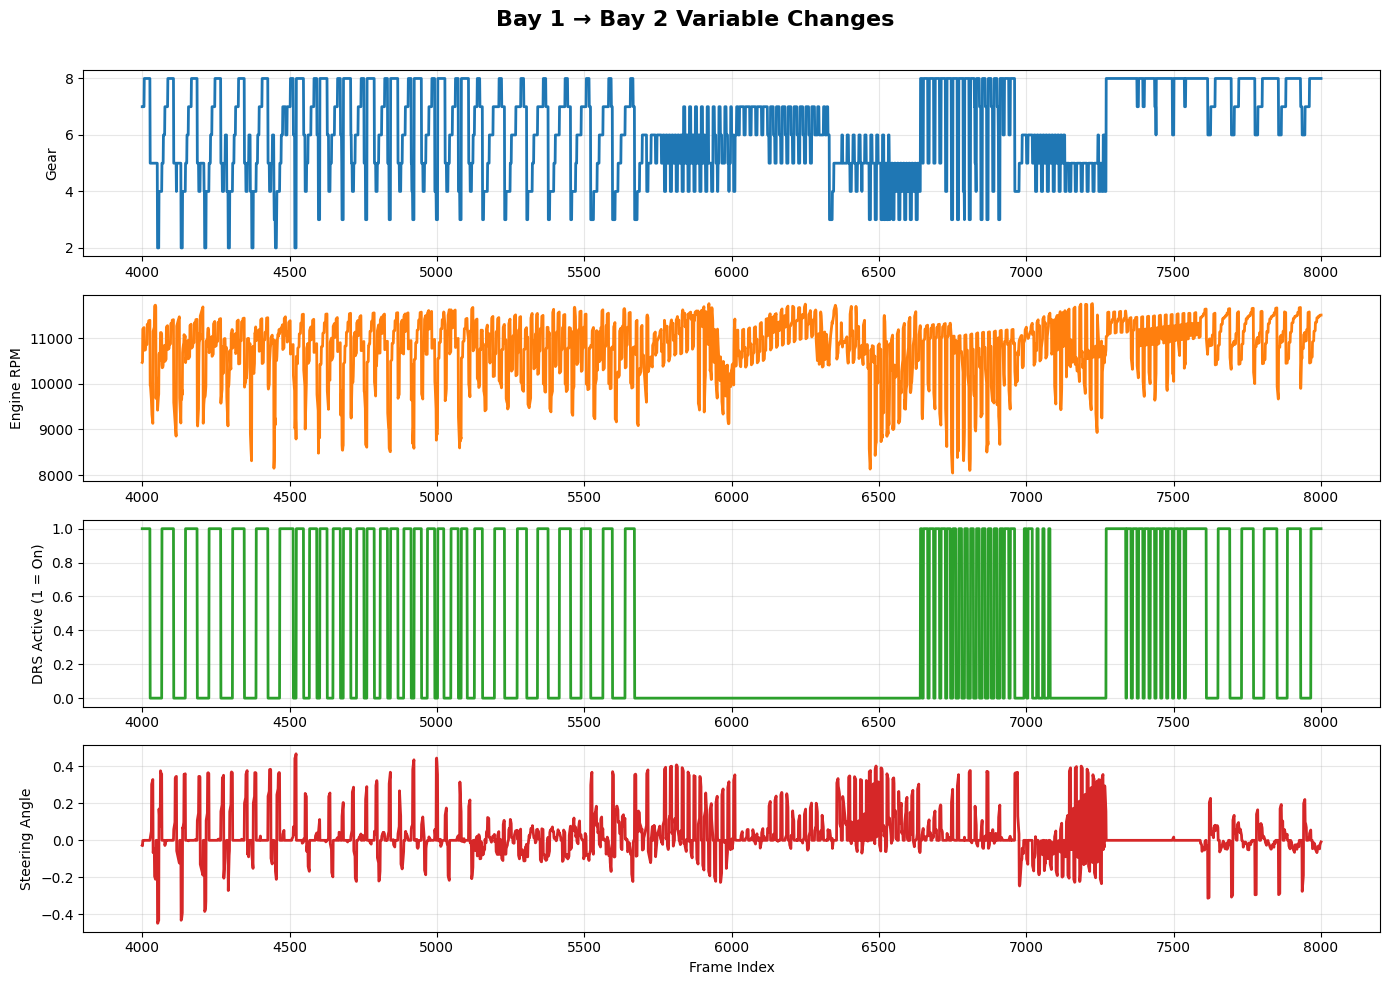

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ========== 1️⃣ Load the data ==========
data_path = "C:/Users/ding0/Desktop/OneDrive_2025-09-22/F1 Racing/UNSW F12024.csv"
f1_cleaned_df = pd.read_csv(data_path)

print("✅ File loaded successfully! Columns available:")
print(f1_cleaned_df.columns.tolist())

# ========== 2️⃣ Define function: Analyze Bay1 → Bay2 transitions ==========
def plot_bay_transition_combined(df, bay1_start, bay2_end, save_path=None):
    """
    Plot the variation of four key telemetry variables between Bay 1 and Bay 2:
    - M_GEAR_1: Gear
    - M_ENGINERPM_1: Engine RPM
    - M_DRS_1: DRS activation state
    - M_STEER_1: Steering angle
    """

    # Select data within Bay 1 → Bay 2 frame range
    bay_df = df[(df.index >= bay1_start) & (df.index <= bay2_end)].copy()

    required_cols = ["M_GEAR_1", "M_ENGINERPM_1", "M_DRS_1", "M_STEER_1"]
    for col in required_cols:
        if col not in bay_df.columns:
            raise ValueError(f"❌ Missing column: {col}. Please check your file headers.")

    plt.figure(figsize=(14, 10))
    plt.suptitle("Bay 1 → Bay 2 Variable Changes", fontsize=16, fontweight="bold")

    # --- Subplot 1: Gear ---
    plt.subplot(4, 1, 1)
    plt.plot(bay_df.index, bay_df["M_GEAR_1"], color="tab:blue", linewidth=2)
    plt.ylabel("Gear")
    plt.grid(alpha=0.3)

    # --- Subplot 2: Engine RPM ---
    plt.subplot(4, 1, 2)
    plt.plot(bay_df.index, bay_df["M_ENGINERPM_1"], color="tab:orange", linewidth=2)
    plt.ylabel("Engine RPM")
    plt.grid(alpha=0.3)

    # --- Subplot 3: DRS ---
    plt.subplot(4, 1, 3)
    plt.plot(bay_df.index, bay_df["M_DRS_1"], color="tab:green", linewidth=2)
    plt.ylabel("DRS Active (1 = On)")
    plt.grid(alpha=0.3)

    # --- Subplot 4: Steering angle ---
    plt.subplot(4, 1, 4)
    plt.plot(bay_df.index, bay_df["M_STEER_1"], color="tab:red", linewidth=2)
    plt.ylabel("Steering Angle")
    plt.xlabel("Frame Index")
    plt.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Figure saved to: {save_path}")

    plt.show()

# ========== 3️⃣ Run the plot ==========
plot_bay_transition_combined(
    f1_cleaned_df,
    bay1_start=4000,
    bay2_end=8000,
    save_path="C:/Users/ding0/Desktop/f1_bay_analysis.png"
)


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bay_transition_combined_by_xy(df, bay1_coords, bay2_coords, save_path=None):
    """
    Plot key variable changes from Bay 1 to Bay 2 (auto-extracting the segment
    by XY coordinates, with a track overlay).

    Parameters
    ----------
    df : pandas.DataFrame
        Telemetry data after the data_pipeline cleaning step. Must contain:
        ["X", "Y", "M_GEAR_1", "M_ENGINERPM_1", "M_DRS_1", "M_STEER_1"].
    bay1_coords : tuple(float, float)
        (x1, y1) — the coordinate center for Bay 1.
    bay2_coords : tuple(float, float)
        (x2, y2) — the coordinate center for Bay 2.
    save_path : str, optional
        If provided, save the figure to this path.

    Returns
    -------
    None
    """

    required_cols = ["X", "Y", "M_GEAR_1", "M_ENGINERPM_1", "M_DRS_1", "M_STEER_1"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Missing required column: {col}")

    x1, y1 = bay1_coords
    x2, y2 = bay2_coords

    # Compute distances to Bay 1 and Bay 2 without modifying df
    dx1 = df["X"].to_numpy() - x1
    dy1 = df["Y"].to_numpy() - y1
    dx2 = df["X"].to_numpy() - x2
    dy2 = df["Y"].to_numpy() - y2
    dist_to_bay1 = np.sqrt(dx1**2 + dy1**2)
    dist_to_bay2 = np.sqrt(dx2**2 + dy2**2)

    # Find nearest frames (by position) to Bay 1 / Bay 2
    start_pos = int(np.argmin(dist_to_bay1))
    end_pos = int(np.argmin(dist_to_bay2))

    # Ensure start <= end
    if start_pos > end_pos:
        start_pos, end_pos = end_pos, start_pos

    # Slice by position to avoid issues with non-monotonic / gapped indices
    segment = df.iloc[start_pos:end_pos + 1].copy()
    if segment.empty:
        raise ValueError("❌ No data found between the given coordinates!")

    # ======== Figure layout ========
    fig = plt.figure(figsize=(14, 11))
    fig.suptitle("Bay 1 → Bay 2 Variable Changes (with Track Overlay)", fontsize=16, fontweight="bold")

    # ======== Track (overview) subplot ========
    ax_track = plt.axes([0.07, 0.70, 0.25, 0.25])  # small map in the upper-left
    ax_track.plot(df["X"], df["Y"], linewidth=1.0, alpha=0.6, color="gray", label="Full Track")
    ax_track.plot(segment["X"], segment["Y"], linewidth=2.5, color="tab:red", label="Bay1 → Bay2")
    ax_track.scatter(*bay1_coords, color="blue", s=40, label="Bay 1")
    ax_track.scatter(*bay2_coords, color="green", s=40, label="Bay 2")

    # Direction arrow (scaled to 20% of the segment vector)
    if len(segment) >= 2:
        dx = (segment["X"].iloc[-1] - segment["X"].iloc[0]) * 0.2
        dy = (segment["Y"].iloc[-1] - segment["Y"].iloc[0]) * 0.2
        ax_track.arrow(segment["X"].iloc[0], segment["Y"].iloc[0], dx, dy,
                       head_width=3, color="red", length_includes_head=True)

    ax_track.set_title("Track Overview")
    ax_track.set_xlabel("X")
    ax_track.set_ylabel("Y")
    ax_track.legend(loc="lower left", fontsize=8)
    ax_track.axis("equal")
    ax_track.grid(alpha=0.3)

    # ======== Time-series subplots ========
    axs = [plt.subplot(4, 1, i + 1) for i in range(4)]

    axs[0].plot(segment.index, segment["M_GEAR_1"], color="tab:blue")
    axs[0].set_ylabel("Gear")

    axs[1].plot(segment.index, segment["M_ENGINERPM_1"], color="tab:orange")
    axs[1].set_ylabel("Engine RPM")

    axs[2].plot(segment.index, segment["M_DRS_1"], color="tab:green")
    axs[2].set_ylabel("DRS (1 = ON)")

    axs[3].plot(segment.index, segment["M_STEER_1"], color="tab:red")
    axs[3].set_ylabel("Steering Angle")
    axs[3].set_xlabel("Frame Index")

    for ax in axs:
        ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Figure saved to: {save_path}")

    plt.show()


In [14]:
print("\n✅ Columns loaded:")
print(df.columns.tolist())



✅ Columns loaded:


NameError: name 'df' is not defined

✅ Figure saved to: C:\Users\ding0\Desktop\f1_bay1_to_bay2_track.png


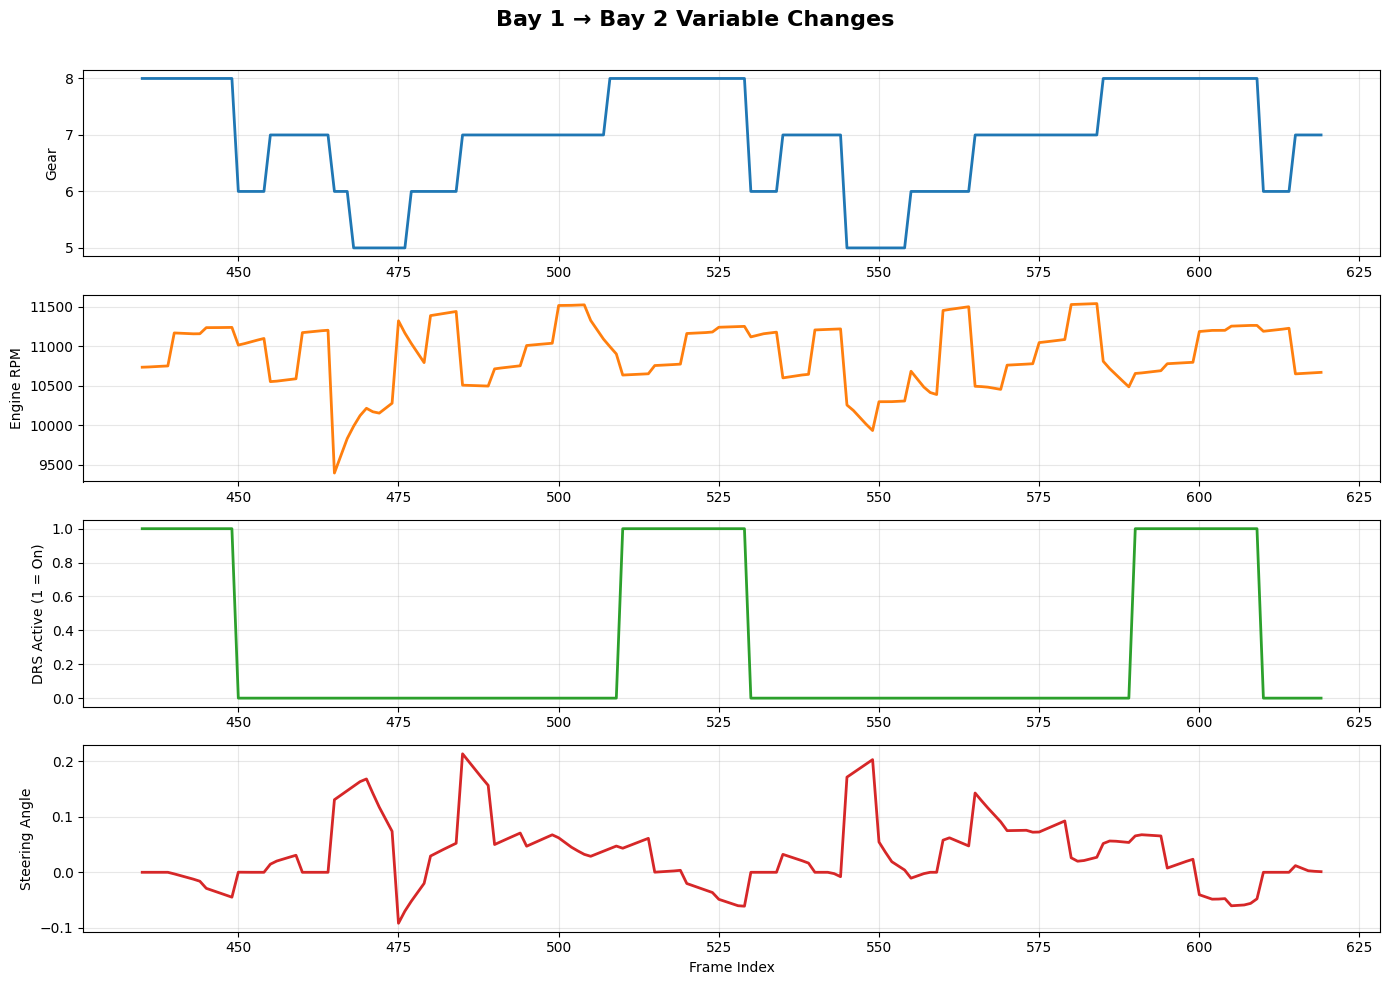

In [ ]:
import matplotlib.pyplot as plt

def plot_bay_transition_combined_by_xy(df, bay1_coords, bay2_coords, save_path=None):
    """
    Plot the variation of four key telemetry variables from Bay 1 to Bay 2:
    - M_GEAR_1: Gear
    - M_ENGINERPM_1: Engine RPM
    - M_DRS_1: DRS activation state
    - M_STEER_1: Steering angle

    Parameters
    ----------
    df : pandas.DataFrame
        The telemetry dataset.
    bay1_coords : tuple
        (x1, y1) — starting frame range coordinates (index-based).
    bay2_coords : tuple
        (x2, y2) — ending frame range coordinates (index-based).
    save_path : str, optional
        If provided, saves the resulting figure to this path.
    """

    # Ensure required columns exist
    required_cols = ["M_GEAR_1", "M_ENGINERPM_1", "M_DRS_1", "M_STEER_1"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Missing required column: {col}")

    # Select data by index range (x: start, y: end)
    bay1_start = bay1_coords[0]
    bay2_end = bay2_coords[0]
    bay_df = df.iloc[bay1_start:bay2_end].copy()

    # Create figure
    plt.figure(figsize=(14, 10))
    plt.suptitle("Bay 1 → Bay 2 Variable Changes", fontsize=16, fontweight="bold")

    # --- Gear ---
    plt.subplot(4, 1, 1)
    plt.plot(bay_df.index, bay_df["M_GEAR_1"], color="tab:blue", linewidth=2)
    plt.ylabel("Gear")
    plt.grid(alpha=0.3)

    # --- Engine RPM ---
    plt.subplot(4, 1, 2)
    plt.plot(bay_df.index, bay_df["M_ENGINERPM_1"], color="tab:orange", linewidth=2)
    plt.ylabel("Engine RPM")
    plt.grid(alpha=0.3)

    # --- DRS activation ---
    plt.subplot(4, 1, 3)
    plt.plot(bay_df.index, bay_df["M_DRS_1"], color="tab:green", linewidth=2)
    plt.ylabel("DRS Active (1 = On)")
    plt.grid(alpha=0.3)

    # --- Steering angle ---
    plt.subplot(4, 1, 4)
    plt.plot(bay_df.index, bay_df["M_STEER_1"], color="tab:red", linewidth=2)
    plt.ylabel("Steering Angle")
    plt.xlabel("Frame Index")
    plt.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save figure (optional)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Figure saved to: {save_path}")

    plt.show()


# ✅ Run the function and save the figure
plot_bay_transition_combined_by_xy(
    df,
    bay1_coords=(435, 1025),
    bay2_coords=(620, 970),
    save_path=r"C:\Users\ding0\Desktop\f1_bay1_to_bay2_track.png"
)
